In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
print("Successful Installation")

C:\Users\chris\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Successful Installation


In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to C:\Users\chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
# ========== STEP 1: Load and Preprocess Your Dataset ==========
# Load your dataset
df = pd.read_csv('text03b.txt', sep='\t')  
df = df[['Text', 'Label']]  # Ensure you have these columns

# Optional: Basic preprocessing (you can skip this if you want raw BERT)
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = word_tokenize(text)
    return ' '.join([w for w in tokens if w not in stop_words])

df['Processed_Text'] = df['Text'].apply(preprocess_text)

In [7]:
# ========== STEP 2: Load BERT Tokenizer and Model ==========
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set model to inference mode
print("Successful Installation")

C:\Users\chris\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical

Successful Installation


In [9]:
# ========== STEP 3: Convert Text to BERT Embeddings ==========
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [10]:
# Generate embeddings
df['BERT_Vector'] = df['Processed_Text'].apply(get_bert_embedding)

# ========== STEP 4: Prepare Data ==========
X = np.vstack(df['BERT_Vector'].values)
y = df['Label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# ========== STEP 5: Train SVM Classifier ==========
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Predict on test set
y_pred = svm.predict(X_test)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.70      0.44      0.54        16
           2       0.54      0.70      0.61        10
           3       0.59      0.70      0.64        23
           4       0.83      0.88      0.85        33

    accuracy                           0.73        95
   macro avg       0.73      0.70      0.70        95
weighted avg       0.74      0.73      0.72        95



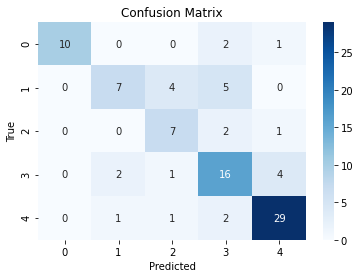

In [12]:
# ========== STEP 6: Evaluation ==========
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# ========== STEP 7: Predict on New Text ==========
new_texts = ["I slept like a baby", "I awake and feel suffocated."]
new_texts_processed = [preprocess_text(text) for text in new_texts]
new_vectors = np.vstack([get_bert_embedding(text) for text in new_texts_processed])
new_predictions = svm.predict(new_vectors)

In [14]:
# Display Results
for text, pred in zip(new_texts, new_predictions):
    print(f"Text: \"{text}\"\nPredicted Label: {pred}\n")

Text: "I slept like a baby"
Predicted Label: 4

Text: "I awake and feel suffocated."
Predicted Label: 3



Fitting 10 folds for each of 11520 candidates, totalling 115200 fits
Best Parameters from GridSearchCV:
 {'C': 4, 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report for model2:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.70      0.44      0.54        16
           2       0.50      0.70      0.58        10
           3       0.62      0.70      0.65        23
           4       0.84      0.82      0.83        33

    accuracy                           0.72        95
   macro avg       0.70      0.70      0.69        95
weighted avg       0.73      0.72      0.71        95



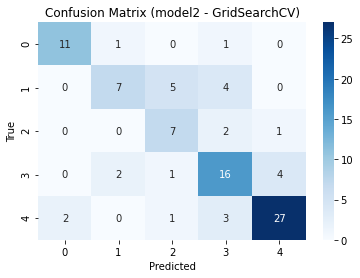

[model2] Text: "I slept like a baby"
Predicted Label: 4

[model2] Text: "I awake and feel suffocated."
Predicted Label: 1



In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# ========== Reuse the X_train, X_test, y_train, y_test from before ==========

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 2,3,4,5,6,7,8,9, 10,20,30,40,50, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1,2,3,4,5,6,7,8,9,10, 'scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different types of kernels
    'degree': [2, 3, 4,5,6,7],  # Degree of the polynomial kernel function (if 'poly' kernel is used)
    'class_weight': [None, 'balanced']  # Use 'balanced' to adjust weights inversely proportional to class frequencies
}

# Create the base SVM model
base_svm = SVC(probability=True)

# Create GridSearchCV object
grid_search = GridSearchCV(base_svm, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best estimator after grid search
model2 = grid_search.best_estimator_

# ========== Evaluate model2 ==========
y_pred2 = model2.predict(X_test)

print("Best Parameters from GridSearchCV:\n", grid_search.best_params_)
print("\nClassification Report for model2:\n", classification_report(y_test, y_pred2))

# Confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (model2 - GridSearchCV)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ========== Predict on New Data ==========
new_predictions2 = model2.predict(new_vectors)

for text, pred in zip(new_texts, new_predictions2):
    print(f"[model2] Text: \"{text}\"\nPredicted Label: {pred}\n")


Fitting 10 folds for each of 6600 candidates, totalling 66000 fits
Best Parameters from GridSearchCV:
 {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 45}

Classification Report for model2 (Random Forest):
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.42      0.31      0.36        16
           2       0.54      0.70      0.61        10
           3       0.50      0.43      0.47        23
           4       0.77      0.91      0.83        33

    accuracy                           0.66        95
   macro avg       0.64      0.64      0.64        95
weighted avg       0.65      0.66      0.65        95



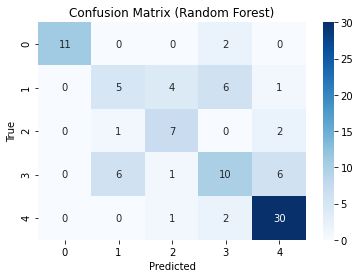

[Random Forest] Text: "I slept like a baby"
Predicted Label: 4

[Random Forest] Text: "I awake and feel suffocated."
Predicted Label: 1



In [19]:
from sklearn.ensemble import RandomForestClassifier

# ========== Reuse X_train, X_test, y_train, y_test from before ==========

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [5,10,15,20,25,30,36,40,45,50],             # Number of trees in the forest
    'max_depth': [None, 2,4,6,8,10,12,14,16,18,20],         # Max depth of the tree
    'min_samples_split': [2, 5, 10],                 # Min samples to split an internal node
    'min_samples_leaf': [1, 2, 3,4,5],                   # Min samples at a leaf node
    'bootstrap': [True, False],                      # Whether bootstrap samples are used
    'class_weight': [None, 'balanced']               # Adjust weights for imbalanced classes
}

# Create the base Random Forest model
base_rf = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(base_rf, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best estimator after grid search
model2 = grid_search.best_estimator_

# ========== Evaluate model2 ==========
y_pred2 = model2.predict(X_test)

print("Best Parameters from GridSearchCV:\n", grid_search.best_params_)
print("\nClassification Report for model2 (Random Forest):\n", classification_report(y_test, y_pred2))

# Confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ========== Predict on New Data ==========
new_predictions2 = model2.predict(new_vectors)

for text, pred in zip(new_texts, new_predictions2):
    print(f"[Random Forest] Text: \"{text}\"\nPredicted Label: {pred}\n")
